<a href="https://colab.research.google.com/github/Centrattic/SEESZooniverse/blob/main/percentage_code/svmPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SVM w/ Color Histograms

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import os
import PIL
from PIL import Image
from tqdm import tqdm
import cv2
from functools import partial

In [ ]:
data_path = "drive/MyDrive/Zooniverse_Images2/"

In [ ]:
image_set = os.listdir(data_path)

TypeError: ignored

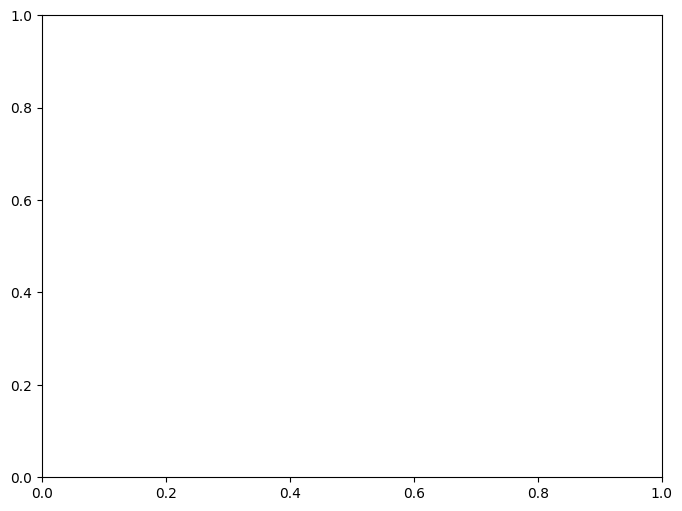

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from PIL import Image

def plot_histogram_2d(image_path, bins=256):
    # Load the image and convert it to grayscale
    image = Image.open(image_path).convert('L')
    image_data = np.array(image)

    # Create the 2D histogram
    hist, x_edges, y_edges = np.histogram2d(
        np.ravel(image_data),
        np.arange(image_data.shape[0]).repeat(image_data.shape[1]),
        bins=[bins, image_data.shape[0]],
        range=[[0, 256], [0, image_data.shape[0]]]
    )

    # Compute the logarithm of the histogram values
    log_hist = np.log1p(hist)

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    pcm = ax.pcolormesh(x_edges, y_edges, log_hist, norm=colors.LogNorm(vmin=log_hist.min(), vmax=log_hist.max()), cmap='viridis')
    fig.colorbar(pcm, ax=ax, label='Logarithmic Frequency')

    # Set labels and title
    ax.set_xlabel('Pixel Value')
    ax.set_ylabel('Row Index')
    ax.set_title('2D Histogram with Logarithmic Color Scale')

    # Show the plot
    plt.show()

# Example usage:
image_path = 'drive/MyDrive/Zooniverse_Images2/3424449.jpg'
plot_histogram_2d(image_path)

In [ ]:
color_histogram = np.zeros((224 * 224 * len(image_set)))

img_arr = np.array(Image.open(data_path + image_set[0]))
resized_img = cv2.resize(img_arr, (224, 224))
flat_img = resized_img.flatten()

for j in range(len(flat_img)):
    color_histogram[j] = flat_img[j]

In [ ]:
hist = color_histogram[color_histogram!=0]

In [ ]:
len(hist)

150519

In [ ]:
os.listdir(data_path)

In [ ]:
img_path = "drive/MyDrive/Zooniverse_Images2/3424449.jpg"

In [ ]:
test_img = cv2.imread(img_path)

In [ ]:
hist_arr = [0] * 3
color_arr = ['red', 'green', 'blue']
for i in range(3):
  hist = test_img[:,:,i].flatten()
  hist_arr[i] = hist

In [ ]:
test_bins = np.linspace(0, 255, 120)

In [ ]:
hist_arr[0]

array([127, 130, 131, ..., 119, 115, 114], dtype=uint8)

AttributeError: ignored

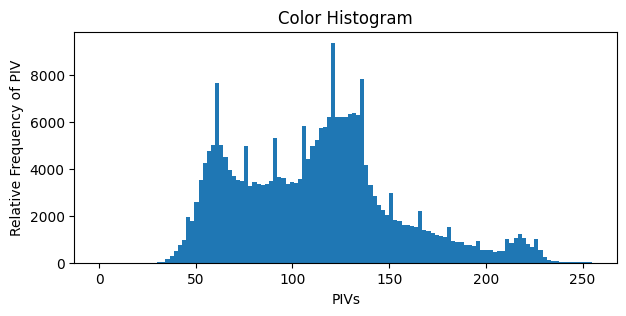

In [ ]:
plt.title("Color Histogram")
plt.xlabel("PIVs")
plt.ylabel("Relative Frequency of PIV")

plt.yscale('linear')

plt.gcf().set_size_inches(7,3)
for i in range(2):
  plt.hist(hist_arr[i], test_bins, ls = 'dashed',edgecolor = None, density = False, histtype = 'barstacked',
           alpha = 0.5, fill=True, norm = colors.LogNorm)

plt.show()

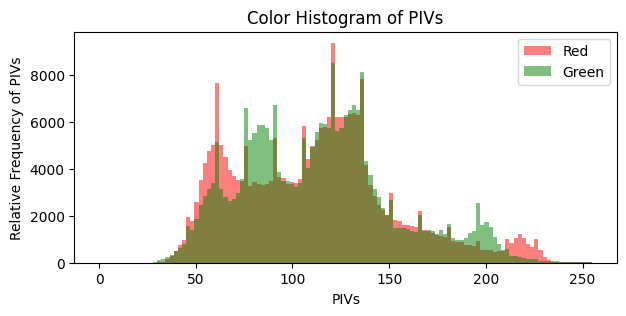

In [ ]:
plt.title("Color Histogram of PIVs")
plt.xlabel("PIVs")
plt.ylabel("Relative Frequency of PIVs")

plt.yscale('linear')

plt.gcf().set_size_inches(7,3)
for i in range(2):
  plt.hist(hist_arr[i], test_bins, edgecolor = None, density = False, histtype = 'barstacked',
           alpha = 0.5, color = color_arr[i])
  plt.legend(['Red', 'Green'])

plt.show()

## data preprocessing

In [ ]:
!pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.3/221.3 kB 3.9 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import torch
import pandas as pd

In [ ]:
from skimage.morphology import skeletonize
from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, Checkpoint, EpochScoring, EarlyStopping
from skorch.dataset import Dataset
from skorch.helper import predefined_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle

from tqdm import tqdm
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
class PretrainedModel(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, output_features)
        self.model = model

    def forward(self, x):
        return self.model(x)

In [ ]:
path = "drive/MyDrive/Colab Notebooks/outputs/checkpoints/water/augmentation_very_high_lr/model.pt"

In [ ]:
model = torch.load(path)  # map_location=torch.device('cpu')

In [ ]:
model = PretrainedModel(2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # change to whatever optimizer was used

checkpoint = torch.load(path) # , map_location=torch.device('cpu')
model.load_state_dict(checkpoint)
conv=model.model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 120MB/s]


In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
# making dataframe with just imagename from folder (98 images) and the data of 512 length in each own individual column
def make_df(i, conv, image_size = (224, 224)):

    # full dataset available in just the test folder
    data_dir = "drive/MyDrive/datasets/water"
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if device == 'cuda:0':
        torch.cuda.empty_cache()

    data_transforms = transforms.Compose([transforms.Resize(image_size), # no lambda transform
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])
    folder = os.path.join(data_dir)
    full_dataset = datasets.ImageFolder(folder, data_transforms)

    subset_index = [i]
    dataset = torch.utils.data.Subset(full_dataset, subset_index)

    # get features
    conv.avgpool.register_forward_hook(get_activation('avgpool'))

    # load into Skorch
    net = NeuralNetClassifier(conv, # model directly, not class. is that okeys?
                              criterion=nn.CrossEntropyLoss,
                              device=device)

    net.initialize() # bc I am not using net.fit (training the model)

    output = net.predict_proba(dataset)
    features_pool = activation['avgpool']

    return full_dataset, features_pool

In [ ]:
for i in tqdm(range(1)):
    ref_dataset, ref_features = make_df(i, conv)

In [ ]:
len(ref_dataset)

In [ ]:
def get_columns(csv, dir):
  cols = list(csv.columns[:-4])
  print(cols)
  cols.append(f'landcovers{dir}PhotoName')

  return cols

def modify_cols(csv, dir):
  df = csv.rename(columns={f'landcovers{dir}PhotoName': 'imageName'})
  df['imageDirection'] = np.array([dir]*len(df))

  return df

def make_image_csv(path):
  csv = pd.read_csv(path)

  westcols = get_columns(csv, 'West')
  northcols = get_columns(csv, 'North')
  eastcols = get_columns(csv, 'East')
  southcols = get_columns(csv, 'South')

  west = modify_cols(csv[westcols], 'West')
  north = modify_cols(csv[northcols], 'North')
  east = modify_cols(csv[eastcols], 'East')
  south = modify_cols(csv[southcols], 'South')

  image_csv = pd.concat([west, north, east, south], axis=0)
  image_csv.reset_index(drop=True)

  return image_csv

In [ ]:
path = "drive/MyDrive/Data_Files/Zooniverse_data.csv"

In [ ]:
image_df = make_image_csv(path)

In [ ]:
image_df.to_csv("drive/MyDrive/Data_Files/Zooniverse_images.csv")

In [ ]:
dataset_loc_arr = [0] * len(ref_dataset)

for i in tqdm(range(len(image_df))):
    for j in range(len(ref_dataset.imgs)):
        if np.array(image_df['imageName'])[i] in ref_dataset.imgs[j][0]:
            dataset_loc_arr[i] = j
            break;

100%|██████████| 5896/5896 [09:35<00:00, 10.25it/s]


In [ ]:
image_df['datasetLoc'] = dataset_loc_arr

In [ ]:
image_df['features'] = np.empty(len(image_df))

In [ ]:
image_df = image_df.reset_index(drop=True)

In [ ]:
np.array(ref_features.to('cpu')).flatten()

In [ ]:
new_image_df = pd.DataFrame()

# dataset loc is a bit convoluted but should work??
# basically we look at each row's position in the dataset, which accounts for skipped rows
# we take the ith image feature value in the dataset, and assign to the row which is the ith
# (bc the dataset is always in same order - order of files in folder)

for i in tqdm(range(len(ref_dataset))):
    # should do len of ref_dataset i think tho, bc that's why i was losing 8

    full_dataset, features_pool = make_df(i, conv)
    flattened_ftrs = np.array(features_pool.to('cpu')).flatten()

    image_row = image_df.loc[image_df['datasetLoc'] == i]
    if image_row.empty == False: # those 8 images
        image_row['features'] = [flattened_ftrs]
        new_image_df = new_image_df.append(image_row)

100%|██████████| 5896/5896 [17:20<00:00,  5.66it/s]


In [ ]:
len(new_image_df.head().iloc[0]['features'])

512

In [ ]:
new_image_df.to_csv("drive/MyDrive/Data_Files/Zooniverse_images_features.csv")

## getting final x and y sets

In [ ]:
new_image_df = pd.read_csv("drive/MyDrive/Data_Files/Zooniverse_images_features.csv")

In [ ]:
zooni_df = pd.read_csv("drive/MyDrive/Data_Files/parsed_zooni_out.csv")

In [ ]:
zooni_df

,Unnamed: 0,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids,water,sky,land,img_name
0,0,501999199,MountainRobot03,2624165.0,a954d9bd77756da2e84f,24748,Choose the Land Cover Categories,6.9,2023-07-19 18:17:59 UTC,NaN,NaN,"{""source"":""api"",""session"":""1592f2abcf85083013e...","[{""task"":""T0"",""task_label"":""Select each of the...","{""90815996"":{""retired"":{""id"":118054626,""workfl...",90815996,0,1,1,3471352.jpg
1,1,501999214,MountainRobot03,2624165.0,a954d9bd77756da2e84f,24748,Choose the Land Cover Categories,6.9,2023-07-19 18:18:02 UTC,NaN,NaN,"{""source"":""api"",""session"":""1592f2abcf85083013e...","[{""task"":""T0"",""task_label"":""Select each of the...","{""90812812"":{""retired"":{""id"":118054627,""workfl...",90812812,0,1,1,3445155.jpg
2,2,501999223,MountainRobot03,2624165.0,a954d9bd77756da2e84f,24748,Choose the Land Cover Categories,6.9,2023-07-19 18:18:05 UTC,NaN,NaN,"{""source"":""api"",""session"":""1592f2abcf85083013e...","[{""task"":""T0"",""task_label"":""Select each of the...","{""90814635"":{""retired"":{""id"":118054630,""workfl...",90814635,0,0,1,3456233.jpg
3,3,501999240,MountainRobot03,2624165.0,a954d9bd77756da2e84f,24748,Choose the Land Cover Categories,6.9,2023-07-19 18:18:09 UTC,NaN,NaN,"{""source"":""api"",""session"":""1592f2abcf85083013e...","[{""task"":""T0"",""task_label"":""Select each of the...","{""90810735"":{""retired"":{""id"":118054631,""workfl...",90810735,0,1,1,3426903.jpg
4,4,501999254,MountainRobot03,2624165.0,a954d9bd77756da2e84f,24748,Choose the Land Cover Categories,6.9,2023-07-19 18:18:13 UTC,NaN,NaN,"{""source"":""api"",""session"":""1592f2abcf85083013e...","[{""task"":""T0"",""task_label"":""Select each of the...","{""90810670"":{""retired"":{""id"":118054636,""workfl...",90810670,1,0,1,3426742.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5891,5891,502055456,not-logged-in-a25b3a3911a6cd660d6b,NaN,a25b3a3911a6cd660d6b,24748,Choose the Land Cover Categories,6.9,2023-07-19 22:26:40 UTC,NaN,NaN,"{""source"":""api"",""session"":""54ecc0d268db46681db...","[{""task"":""T0"",""task_label"":""Select each of the...","{""90810624"":{""retired"":{""id"":118057742,""workfl...",90810624,1,1,1,3426619.jpg
5892,5892,502055478,not-logged-in-a25b3a3911a6cd660d6b,NaN,a25b3a3911a6cd660d6b,24748,Choose the Land Cover Categories,6.9,2023-07-19 22:26:47 UTC,NaN,NaN,"{""source"":""api"",""session"":""54ecc0d268db46681db...","[{""task"":""T0"",""task_label"":""Select each of the...","{""90816433"":{""retired"":{""id"":118058754,""workfl...",90816433,0,1,1,3482798.jpg
5893,5893,502055508,not-logged-in-a25b3a3911a6cd660d6b,NaN,a25b3a3911a6cd660d6b,24748,Choose the Land Cover Categories,6.9,2023-07-19 22:26:57 UTC,NaN,NaN,"{""source"":""api"",""session"":""54ecc0d268db46681db...","[{""task"":""T0"",""task_label"":""Select each of the...","{""90816472"":{""retired"":{""id"":118062310,""workfl...",90816472,0,0,0,3482851.jpg
5894,5894,502055607,not-logged-in-a25b3a3911a6cd660d6b,NaN,a25b3a3911a6cd660d6b,24748,Choose the Land Cover Categories,6.9,2023-07-19 22:27:34 UTC,NaN,NaN,"{""source"":""api"",""session"":""d3f380f3d52ce6ab4b0...","[{""task"":""T0"",""task_label"":""Select each of the...","{""90814710"":{""retired"":{""id"":118061412,""workfl...",90814710,1,1,1,3457726.jpg


In [ ]:
label_dict = {0:'trees', 1:'shrubs', 2:'herbaceous/grassland', 3:'barren', 4:'wetlands',
              5:'open water', 6:'cultivated', 7:'urban'}

class_dict = {0: ['01', '02', '03', '00', '11', '12', '13', '1'], # 0 or 1
              1: ['21', '22', '23','31','32','33','3'], # 2 or 3
              2: ['41', '42', '43', '44'], #4
              3: ['51','52','53','54','55','56'], # 5
              4: ['61','63','64'], # 6
              5: ['71', '72'], # 7
              6: ['811','812','814','82'], # 8
              7: ['91', '92', '93','94']} # 9

short_class_dict = {0: ['0', '1'], 1: ['2','3'], 2: ['4'], 3: ['5'], 4: ['6'],
                    5: ['7'], 6: ['8'], 7: ['9']}

# conclusion. I only need to look at the first digit

In [ ]:
word = '30% MUC 11 (b) [Trees, Loosely Spaced, Evergreen - Broad Leaved]; 30% MUC 12 (b) [Trees, Loosely Spaced, Deciduous - Broad Leaved]; 90% MUC 81 (1) [Cultivated, Crops or Pastures]; 10% MUC 92 [Urban, Commercial Property]'
[m.start() for m in re.finditer('MUC', word)]


[4, 70, 136, 184]

In [ ]:
word[4+4:4+7] # +4 to the classification

'11 '

In [ ]:
[m.start() for m in re.finditer('%', word)]

[2, 68, 134, 182]

In [ ]:
int(word[68-3:68])

30

In [ ]:
def floor_zero(num):
  if num > 0:
    return num
  if num < 0:
    return 0
  if num == 0:
    return 0

In [ ]:
def make_xy(csv, zooni_csv, short_class_dict, label_dict):
  nan_idxs = [] # to drop
  new_df = pd.DataFrame()
  for index in tqdm(csv.index): # all the ranges # i in csv gives us COLUMN not row
    i = csv[index:index+1] # that single row, hopefully edits happen
    # add classification percentages
    dir = i['imageDirection'][index]
    # print(dir[index])
    classification = i[f'landcovers{dir}Classifications'][index] # ex. landcoversNorthClassifications
    if pd.isnull(classification):
      nan_idxs.append(index)
    else:
      nums_check = []
      nums = np.array(re.findall('\d+', classification))

      mucs = np.array([m.start() for m in re.finditer('MUC', classification)]).astype(int)
      percents = np.array([m.start() for m in re.finditer('%', classification)]).astype(int)
      for p in range(len(mucs)):
        # print(classification)
        percent_clas = np.array(re.findall('\d+', classification[floor_zero(percents[p]-3):percents[p]]))[0]
        mucs_clas = np.array(re.findall('\d+', classification[mucs[p]+4:mucs[p]+7]))[0] # findall removes all spaces/other annoying things
        nums_check.append(percent_clas)
        nums_check.append(mucs_clas)

      new_nums = np.array(nums_check) # no point of nums lol ig
      try:
        if(len(new_nums) != 2):
          nums_reshape = new_nums.reshape(2,int(len(new_nums)/2))
        if(len(new_nums) == 2):
          nums_reshape=list([new_nums]) # making 2D array
      except:
        print(classification)
        print()
        print(new_nums)

      for j in nums_reshape:
        # print(j)
        mucid = str(j[1])[0] # first identifier
        for k in short_class_dict.values():
          classid = list(short_class_dict.keys())[list(short_class_dict.values()).index(k)]
          classname = label_dict[classid]
          if mucid in k: # will only be in one
            i[f'{classname}'] = int(j[0])/100 # adding value to df
          if mucid not in k:
            i[f'{classname}'] = 0


    # get zooni_csv values
    imagename = i['imageName'][index]
    relevant_row = zooni_csv[zooni_csv['img_name'] == imagename]
    assert(len(relevant_row) == 1)
    i[['water', 'land', 'sky']] = np.array(relevant_row[['water', 'land', 'sky']])

    new_df = new_df.append(i)

  return new_df, nan_idxs

In [ ]:
processed_csv, nan_idxs = make_xy(new_image_df, zooni_df, short_class_dict, label_dict)

100%|██████████| 5896/5896 [01:03<00:00, 92.88it/s]


In [ ]:
final_csv = processed_csv.drop(nan_idxs)

In [ ]:
final_csv.to_csv("drive/MyDrive/Data_Files/svm_final.csv")

In [ ]:
final_csv.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'protocol', 'measuredDate', 'createDate',
       'updateDate', 'publishDate', 'organizationId', 'organizationName',
       'siteId', 'siteName', 'countryName', 'countryCode', 'latitude',
       'longitude', 'elevation', 'pid', 'landcoversDownwardPhotoUrl',
       'landcoversEastExtraData', 'landcoversEastPhotoUrl',
       'landcoversLocationAccuracyM', 'landcoversMucCode',
       'landcoversUpwardPhotoUrl', 'landcoversEastCaption',
       'landcoversMeasurementLatitude', 'landcoversWestClassifications',
       'landcoversNorthCaption', 'landcoversNorthExtraData',
       'landcoversDataSource', 'landcoversDryGround', 'landcoversWestCaption',
       'landcoversSouthClassifications', 'landcoversNorthPhotoUrl',
       'landcoversUpwardCaption', 'landcoversDownwardExtraData',
       'landcoversEastClassifications', 'landcoversMucDetails',
       'landcoversLocationMethod', 'landcoversMeasuredAt',
       'landcoversDownwardCaption', 'landcoversSouthPhotoU

## test models

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import scipy

Let's do this per class. No cross val.

In [ ]:
final_df = pd.read_csv("drive/MyDrive/Data_Files/svm_final.csv")

In [ ]:
label_dict = {0:'trees', 1:'shrubs', 2:'herbaceous/grassland', 3:'barren', 4:'wetlands',
              5:'open water', 6:'cultivated', 7:'urban'}

In [ ]:

def features_df(df, class_name):
    df = df.reset_index(drop=True)
    X=df['features']
    X_list = [0] * len(X)
    for i in range(len(X)):
        mod_X = X[i][1:]
        mod_2X = mod_X[:-1]
        X_list[i] = np.array(np.fromstring(mod_2X, dtype=float, sep=' '))
    X_df = pd.DataFrame(X_list)
    X_df[['water', 'land', 'sky']] = df[['water', 'land', 'sky']]

    y = np.array(df[f'{class_name}'])

    return X_df, y

In [ ]:
def get_splits(df, class_num, label_dict): # maybe add image dir after and see how much weight it got
  class_name = label_dict[class_num]
  cols = ['imageName', 'features',  'water', 'land', 'sky', class_name]
  X = df[cols]
  # we can try this later, balancing classes ah = cut_csv[cut_csv[class_name] != 0]

  num_zero_keep = len(X[X[class_name] != 0])
  df_zero = X[X[class_name] == 0]
  indices_zero = (df_zero).index
  drop_indices = np.random.choice(indices_zero, int(len(indices_zero) - num_zero_keep/5), replace=False)
  X = X.drop(drop_indices, axis=0)

  print(len(X))

  X_df, y = features_df(X, class_name)
  nonzero_y = (y>0).astype(int) # for stratification only

  X_train, X_test, y_train, y_test = train_test_split(X_df , y, test_size = 0.2, stratify=nonzero_y, random_state = 86)

  X_train = X_train.reset_index(drop=True)
  X_test = X_test.reset_index(drop=True)

  return X_train, X_test, y_train, y_test

In [ ]:
def train_test_model(df, class_num, label_dict):
    X_train, X_test, y_train, y_test = get_splits(df, class_num, label_dict)

    # svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
    # svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)
    # svr_lin = SVR(kernel="poly", degree = 120, C=10, gamma="scale"), clf = make_pipeline(StandardScaler(), svr_lin)
    # clf = LinearRegression()
    regressor = DecisionTreeRegressor(random_state=86)
    cross_val_score(regressor, X, y, cv=10)


    clf.fit(X_train[:].values, y_train) # only values no header

    preds = clf.predict(X_test[:].values)
    return clf, preds, y_test, X_train

In [ ]:
clf, preds, y_test, X_train = train_test_model(final_df,5, label_dict)

160


In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,water,land,sky
0,0.156682,0.544455,1.168823,0.222908,0.113312,1.420613,0.619419,0.388168,0.956613,1.336461,...,0.465926,1.117562,0.830627,1.235641,0.274298,1.010259,1.225062,0,1,1
1,2.479974,0.091244,0.275835,0.162278,0.157234,0.553682,1.779637,3.201842,3.881706,0.349521,...,0.323870,1.134562,0.015164,0.406770,1.130457,1.355548,0.557614,1,1,1
2,0.913267,0.254065,0.457749,0.078389,0.895416,1.335853,0.006378,0.520716,2.486288,0.267494,...,0.520365,0.520569,3.509817,0.012047,0.817769,2.609023,0.480241,1,1,0
3,0.201777,0.670976,0.497371,0.225935,0.074104,0.262568,0.140983,0.448007,1.788635,0.330094,...,1.102799,1.772145,0.072216,0.815493,0.682240,0.448326,0.375660,0,1,1
4,0.221349,2.651493,1.686017,0.391896,0.243863,1.226999,0.000000,0.217658,0.746010,1.074220,...,0.629728,1.265595,1.236949,0.049249,1.708826,0.150156,0.208446,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,1.000749,0.000000,0.335330,0.923201,0.066468,0.497983,0.034587,0.885978,0.676861,0.016695,...,0.150726,0.338351,0.188168,1.810821,0.116170,0.389582,1.639830,1,1,1
124,0.541831,1.433851,0.166100,0.405206,0.070704,1.334211,0.000000,0.018138,1.693227,0.415823,...,1.195693,1.704087,0.431502,0.060398,0.160687,0.012416,0.681343,0,1,0
125,0.672413,2.858837,1.247775,0.250124,0.000000,2.368288,0.013859,0.022830,0.754624,1.279889,...,1.237345,1.296458,2.429547,0.070533,0.474470,1.890727,0.478275,0,1,1
126,0.117534,1.067656,0.327422,0.377484,0.331776,2.435990,0.041633,0.867049,1.771649,0.028136,...,0.526172,0.252179,0.861685,0.776066,0.720133,1.383945,1.774894,0,1,1


In [ ]:
def floor_zero(num):
  if num > 0:
    return num
  if num < 0:
    return 0
  if num == 0:
    return 0

In [ ]:
attempt = [floor_zero(i) for i in (preds-0.6)]

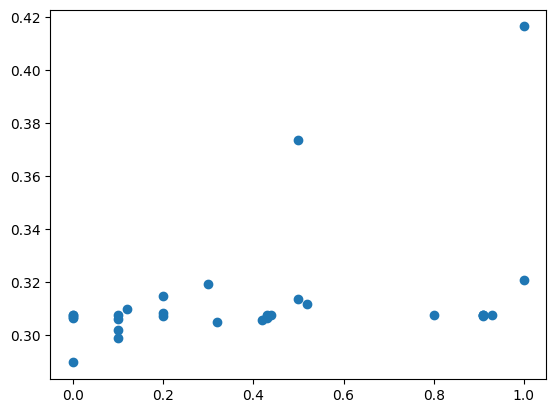

In [ ]:
plt.scatter(y_test, preds)

In [ ]:
y_test

array([0.8 , 0.1 , 0.43, 0.43, 0.1 , 0.12, 1.  , 0.3 , 0.  , 0.52, 0.91,
       0.  , 1.  , 0.44, 0.32, 0.  , 0.1 , 0.93, 0.91, 0.91, 0.  , 0.5 ,
       0.42, 0.5 , 0.  , 0.43, 0.2 , 0.1 , 0.2 , 0.91, 0.2 , 0.43])

In [ ]:
np.round(preds, 2)

array([0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24,
       0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24,
       0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24])

In [ ]:
print('yay')

Future Work
* split into grid and have cnn predict the three classes
* use color histograms with 10 size bins (75 features)
* choose 12 or more colors, and assign each pixel's similarity with a color. Then get percentage of each color and just pass that in to the model